# Check which GPU we have

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sun Oct 29 18:54:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

##Installing Prerequisites

In [ ]:
!pip install transformers[torch]
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

#Reading Data
We will rely on the following libraries for training and evaluation:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/komari6/Arabic-twitter-corpus-AJGT.git

Cloning into 'Arabic-twitter-corpus-AJGT'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (9/9), 102.95 KiB | 941.00 KiB/s, done.


**Question 1:** Read the dataset and arrange the columns name using the set variables:

In [ ]:
file_path = '/content/Arabic-twitter-corpus-AJGT/AJGT.xlsx'


In [ ]:



df = pd.read_excel(file_path)

# Assigning column names
df.columns = [INDEX_COLUMN, DATA_COLUMN, LABEL_COLUMN]


**Question 2**: Split the data into training and testing (80-20)

In [ ]:
from sklearn.model_selection import train_test_split


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[DATA_COLUMN], df[LABEL_COLUMN], test_size=0.20, random_state=42)


**Question 3:** Plot the distribution of lengths of sentences in both training and test set. Extract the max_len value to be used later:

In [ ]:
X_train.str.len().describe()

count    1440.000000
mean       45.583333
std        40.750124
min         6.000000
25%        23.000000
50%        36.000000
75%        57.000000
max       864.000000
Name: text, dtype: float64

In [ ]:
X_test.str.len().describe()

count    360.000000
mean      51.691667
std       62.792020
min        7.000000
25%       23.000000
50%       35.000000
75%       59.500000
max      683.000000
Name: text, dtype: float64

<Axes: >

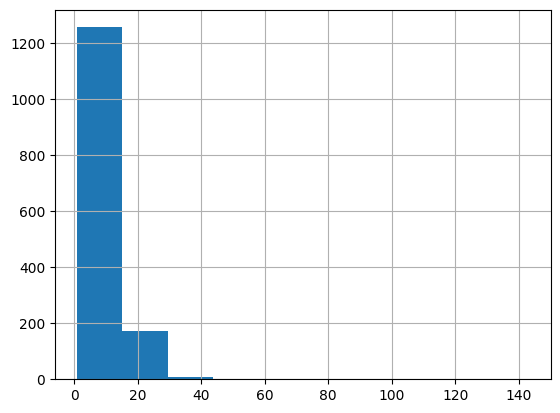

In [ ]:
X_train.str.split().str.len().hist()

<Axes: >

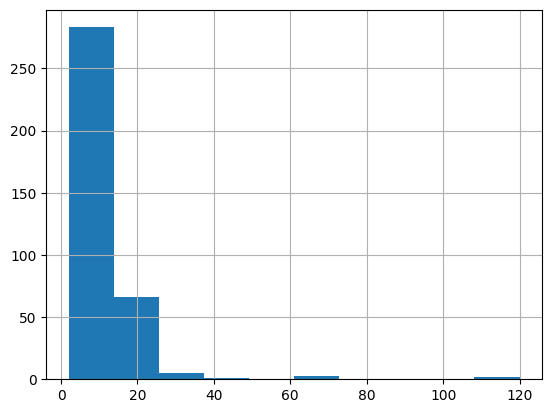

In [ ]:
X_test.str.split().str.len().hist()

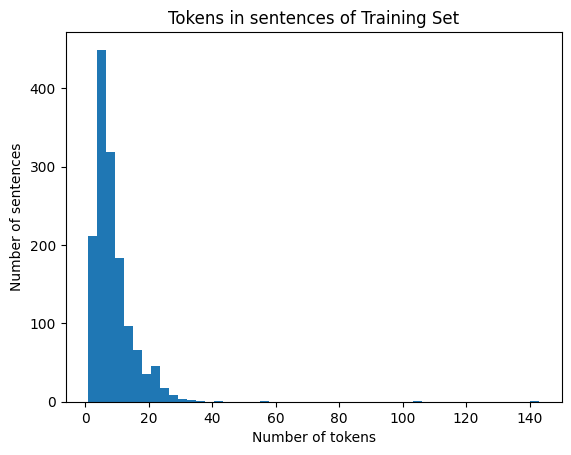

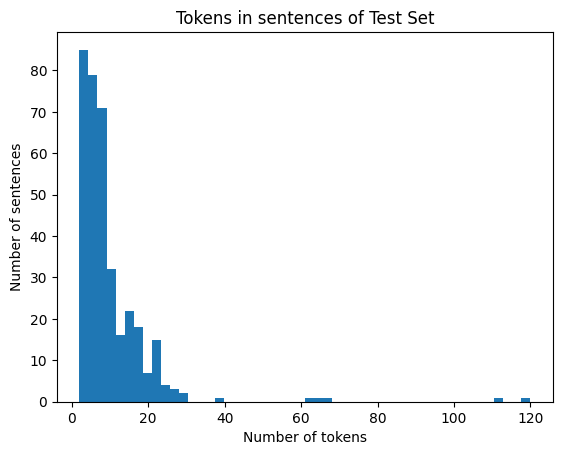

In [ ]:
# Plotting the distribution of sentence lengths in the training set
plt.hist([len(s.split()) for s in X_train], bins=50)
plt.title('Tokens in sentences of Training Set')
plt.xlabel('Number of tokens')
plt.ylabel('Number of sentences')
plt.show()

# Plotting the distribution of sentence lengths in the test set
plt.hist([len(s.split()) for s in X_test], bins=50)
plt.title('Tokens in sentences of Test Set')
plt.xlabel('Number of tokens')
plt.ylabel('Number of sentences')
plt.show()

# You can choose the max_len based on the histograms
max_len = 128  # You can adjust this value based on your observation


We can conclude that the max_len can be chosen to be ___.

#Training Requirements

Let's start by creating the dataset needed for training and testing, we will use the Dataset class from pytorch as our base class.

For tokenization, we will be using the autotokenizer from HuggingFace.

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers.data.processors.utils import InputFeatures
from transformers import AutoTokenizer

#define the Dataset class
class SADataset(Dataset):
  def __init__(self, texts, labels, model_name, max_len, label_map):
    #hold the text and reviews inside the dataset class
    self.texts = texts
    self.labels = labels
    self.label_map = label_map
    self.tokenizer_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_len = max_len

  def __len__(self):
    #returns the length of the dataset
    return len(self.texts)

  def __getitem__(self, item):
    # Select the example based on the item ID
    text = str(self.texts[item])
    label = self.labels[item]

    input_dict = self.tokenizer(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding = 'max_length',
          truncation= True
      )

    return InputFeatures(input_ids=input_dict["input_ids"],
                         token_type_ids=input_dict['token_type_ids'],
                         attention_mask=input_dict["attention_mask"],
                         label=self.label_map[self.labels[item]])

**Question 4:** Define the evaluation metrics that we will need, including `accuracy_score`, `f1_score`, `precision_score` and `recall_score` from sklearn.

In [ ]:
def compute_metrics(pred):
  preds = np.argmax(pred.predictions, axis=1)
  assert len(preds) == len(pred.label_ids)
  """
  Add metrics calls here
  """
  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

## Preprocess the dataset
Let's start by defining the AraBERT preprocessor:

In [ ]:
from arabert.preprocess import ArabertPreprocessor

model_name = 'aubmindlab/bert-base-arabertv02'
arabert_prep = ArabertPreprocessor(model_name)

**Question 5:** Apply preprocessing for the text column using the arabert preprocessor:

In [ ]:
# Applying the arabert preprocessor to the 'text' column
X_train = X_train.apply(lambda x: arabert_prep.preprocess(x))
X_test = X_test.apply(lambda x: arabert_prep.preprocess(x))



Let's extract the label to id map:

In [ ]:
label_list = list(preprocessed_df[LABEL_COLUMN].unique())
label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

{'Positive': 0, 'Negative': 1}


**Question 6:** Create the train and test SADataset:

In [ ]:
# Defining the SADataset class
class SADataset(Dataset):
    def __init__(self, texts, labels, model_name, max_len, label_map):
        self.texts = texts
        self.labels = labels
        self.label_map = label_map
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        input_dict = self.tokenizer(text, add_special_tokens=True, max_length=self.max_len,
                                    padding='max_length', truncation=True)

        return InputFeatures(input_ids=input_dict["input_ids"], token_type_ids=input_dict['token_type_ids'],
                             attention_mask=input_dict["attention_mask"], label=self.label_map[self.labels[item]])


In [ ]:

train_dataset = SADataset(texts=X_train.tolist(), labels=y_train.tolist(), model_name=model_name,
                          max_len=max_len, label_map=label_map)

test_dataset = SADataset(texts=X_test.tolist(), labels=y_test.tolist(), model_name=model_name,
                         max_len=max_len, label_map=label_map)



# Setup the HuggingFace trainer

We will be using the `bert-base-arabertv02` from HuggingFace models by Antoun et Al (2020). We can choose other Arabic BERT models by just changing the path here from `https://huggingface.co/models`.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can now set up the training arguments, you can more information from https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [ ]:
from transformers import Trainer , TrainingArguments

training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 4,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_macro_f1',
    greater_is_better = True,
    seed = 42
  )

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

# Setting up the training arguments
training_args = TrainingArguments(output_dir="./train", num_train_epochs=4, per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16, warmup_steps=500, weight_decay=0.01, logging_dir='./logs',
                                  logging_steps=10, load_best_model_at_end=True, evaluation_strategy="steps")

# Initializing the Trainer
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)

# Training the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
10,0.732900,0.722268
20,0.706400,0.687851
30,0.717500,0.639865
40,0.665500,0.592796
50,0.613700,0.542427
60,0.538400,0.488228
70,0.491700,0.422449
80,0.418500,0.364675
90,0.340000,0.294171
100,0.351100,0.248558


TrainOutput(global_step=360, training_loss=0.25690592800577483, metrics={'train_runtime': 93.33, 'train_samples_per_second': 61.716, 'train_steps_per_second': 3.857, 'total_flos': 378879919718400.0, 'train_loss': 0.25690592800577483, 'epoch': 4.0})

**Question:** Initialize the Trainer and start training:

In [ ]:
# After training the model, save it, including its configuration and tokenizer

# Saving the model, configuration, and tokenizer
def save_model(model, tokenizer, output_dir="./model"):
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f'Model saved in {output_dir}')

# Save the trained model
save_model(trainer.model, train_dataset.tokenizer, output_dir="./model")


Model saved in ./model


#  Saving the best model

Before saving the model, let's change the label2id in the config file, and get the id to label map.

In [ ]:
#save the model in the folder
trainer.save_model("best_sa_model")
test_dataset.tokenizer.save_pretrained("best_sa_model")

# Loading the model for inference
We can use HuggingFace pipelines to load the model for inference:

In [ ]:
from transformers import pipeline
pipe = pipeline(
        "sentiment-analysis",
        model = "model",
        device=0, # set device to 0 for CUDA
        )

In [ ]:
pipe("انا لا احبك")

[{'label': 'LABEL_1', 'score': 0.9940647482872009}]

In [ ]:
pipe("انا احبك")

[{'label': 'LABEL_0', 'score': 0.9958733916282654}]